 <H2>Hodgkin–Huxley model using Parameters</H2>

To make HH model work with rxd with have added crxd.v to represent the voltage in Rates and Reactions, we have also added vtrap(x,y) to avoid a discontinuity, vtrap(x,y) is 1/(exp(x/y)-1) if |x/y|>=1e-6 or y*(1.0 - x/y/2.0) otherwise.

In [1]:
from neuron import h, crxd as rxd
from neuron.crxd import v
from neuron.crxd.rxdmath import vtrap, exp, log
from math import pi
from matplotlib import pyplot
h.load_file('stdrun.hoc')

1.0

Set the parameters and the Boltzmann equations for the sodium and potassium gates.

In [2]:
# parameters
h.celsius = 6.3 
e = 1.60217662e-19
scale = 1e-14/e
gnabar = 0.12*scale     # molecules/um2 ms mV 
gkbar = 0.036*scale
gl = 0.0003*scale
el = -54.3
q10 = 3.0**((h.celsius - 6.3)/10.0)

# sodium activation 'm'
alpha = 0.1 * vtrap(-(v + 40.0), 10)
beta = 4.0 * exp(-(v + 65)/18.0)
mtau = 1.0/(q10 * (alpha + beta))
minf = alpha/(alpha + beta)


# sodium inactivation 'h'
alpha = 0.07 * exp(-(v + 65.0)/20.0)
beta = 1.0/(exp(-(v + 35.0)/10.0) + 1.0)
htau = 1.0/(q10 * (alpha + beta))
hinf = alpha/(alpha + beta)

# potassium activation 'n'
alpha = 0.01 * vtrap(-(v + 55.0), 10.0)
beta = 0.125 * exp(-(v + 65.0)/80.0)
ntau = 1.0/(q10 * (alpha + beta))
ninf = alpha/(alpha + beta)


Define two cylinders; one with for Hodgkin-Huxley mod file the for using rxd.

In [3]:
somaA = h.Section('somaA')
somaA.pt3dclear()
somaA.pt3dadd(-90,0,0,30)
somaA.pt3dadd(-60,0,0,30)
somaA.nseg = 11

somaB = h.Section('somaB')
somaB.pt3dclear()
somaB.pt3dadd(60,0,0,30)
somaB.pt3dadd(90,0,0,30)
somaB.nseg = 11

Define the rxd model following the standard Where/Who/What specification.

In [4]:
# Where?
# intracellular
cyt = rxd.Region(h.allsec(), name='cyt', nrn_region='i')

# membrane
mem = rxd.Region(h.allsec(), name='cell_mem', geometry = rxd.membrane())

# extracellular
ecs = rxd.Extracellular(-100, -100, -100, 100, 100, 100, dx=33)

# Who?  ions & gates

# intracellular sodium & potassium
na = rxd.Species([cyt, mem], name='na', d=1, charge=1, initial=10)
k = rxd.Species([cyt, mem], name='k', d=1, charge=1, initial=54.4)

# extracellular parameters provide a constant concentration for the Nernst potential and reactions.
kecs = rxd.Parameter([ecs], name='kecs', charge=1, value=2.5)
naecs = rxd.Parameter([ecs], name='naecs', charge=1, value=140)

# an undistinguished charged ion for the leak current
x = rxd.Parameter([cyt, mem, ecs], name='x', charge=1) 

# define the various species and parameters on the intracellular and extracellular regions
ki, ko, nai, nao, xi, xo = k[cyt], kecs[ecs], na[cyt], naecs[ecs], x[cyt], x[ecs]

# the gating states               
ngate = rxd.State([cyt, mem], name='ngate', initial=0.24458654944007166)
mgate = rxd.State([cyt, mem], name='mgate', initial=0.028905534475191907)
hgate = rxd.State([cyt, mem], name='hgate', initial=0.7540796658225246)

# parameter to limit rxd reaction to somaA
pA = rxd.Parameter([cyt, mem], name='paramA',
                       initial=lambda nd: 1 if nd.segment in somaA else 0)

#What? gates and currents 
m_gate = rxd.Rate(mgate, (minf - mgate)/mtau)
h_gate = rxd.Rate(hgate, (hinf - hgate)/htau)
n_gate = rxd.Rate(ngate, (ninf - ngate)/ntau)

# Nernst potentials
ena = 1e3*h.R*(h.celsius + 273.15)*log(nao/nai)/h.FARADAY
ek = 1e3*h.R*(h.celsius + 273.15)*log(ko/ki)/h.FARADAY

gna = pA*gnabar*mgate**3*hgate
gk = pA*gkbar*ngate**4

na_current = rxd.MultiCompartmentReaction(nai, nao, gna*(v - ena),
                                          mass_action=False, membrane=mem,
                                          membrane_flux=True)
k_current = rxd.MultiCompartmentReaction(ki, ko, gk*(v - ek),
                                         mass_action=False, membrane=mem,
                                         membrane_flux=True)
leak_current = rxd.MultiCompartmentReaction(xi, xo, pA*gl*(v - el),
                                         mass_action=False, membrane=mem,
                                         membrane_flux=True)


Mod version is included with the NEURON distribution, defined <a href=https://raw.githubusercontent.com/neuronsimulator/nrn/master/src/nrnoc/hh.mod>here</a>.

In [5]:
somaB.insert('hh')

__nrnsec_0x55832d8d0680

Next add a current source and record the membrane potentials and states of the gates.

In [6]:
# stimulate
stimA = h.IClamp(somaA(0.5))
stimA.delay = 50
stimA.amp = 1
stimA.dur = 50

stimB = h.IClamp(somaB(0.5))
stimB.delay = 50
stimB.amp = 1
stimB.dur = 50

# record
tvec = h.Vector().record(h._ref_t)

vvecA = h.Vector().record(somaA(0.5)._ref_v)
mvecA = h.Vector().record(mgate.nodes(somaA(0.5))[0]._ref_value)
nvecA = h.Vector().record(ngate.nodes(somaA(0.5))[0]._ref_value)
hvecA = h.Vector().record(hgate.nodes(somaA(0.5))[0]._ref_value)
kvecA = h.Vector().record(somaA(0.5)._ref_ik)
navecA = h.Vector().record(somaA(0.5)._ref_ina)
kvecAo = h.Vector().record(somaA(0.5)._ref_ikecs)
navecAo = h.Vector().record(somaA(0.5)._ref_inaecs)

vvecB = h.Vector().record(somaB(0.5)._ref_v)
kvecB = h.Vector().record(somaB(0.5)._ref_ik)
navecB = h.Vector().record(somaB(0.5)._ref_ina)
mvecB = h.Vector().record(somaB(0.5).hh._ref_m)
nvecB = h.Vector().record(somaB(0.5).hh._ref_n)
hvecB = h.Vector().record(somaB(0.5).hh._ref_h)
tvec = h.Vector().record(h._ref_t)

Run the simulation.

In [7]:
h.finitialize(-70)
h.continuerun(100)

0.0

Plot the results.

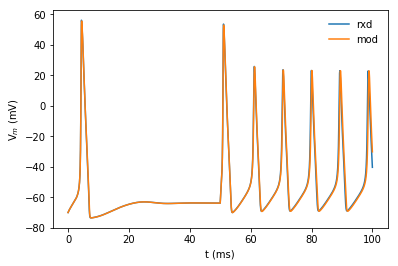

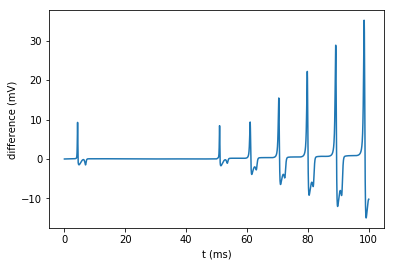

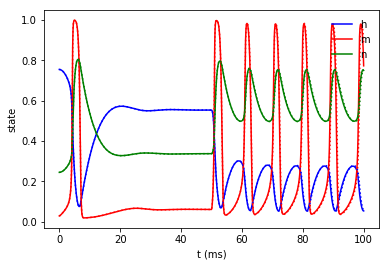

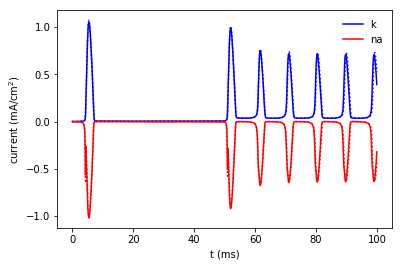

In [8]:
fig = pyplot.figure()
pyplot.plot(tvec, vvecA, label="rxd")
pyplot.plot(tvec, vvecB, label="mod")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, vvecA.as_numpy() - vvecB.as_numpy())
pyplot.xlabel('t (ms)')
pyplot.ylabel('difference (mV)')

fig = pyplot.figure()
pyplot.plot(tvec, hvecA, '-b', label='h')
pyplot.plot(tvec, mvecA, '-r', label='m')
pyplot.plot(tvec, nvecA, '-g', label='n')
pyplot.plot(tvec, hvecB, ':b')
pyplot.plot(tvec, mvecB, ':r')
pyplot.plot(tvec, nvecB, ':g')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecA.as_numpy() + kvecAo.as_numpy(), '-b', label='k')
pyplot.plot(tvec, navecA.as_numpy() + navecAo.as_numpy(), '-r', label='na')
pyplot.plot(tvec, kvecB, ':b')
pyplot.plot(tvec, navecB, ':r')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)